In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import re
import concurrent.futures
from tqdm import tqdm

In [ ]:
keyTestTPath = 'data/origin_files/key_test_t.csv'
df = pd.read_csv(keyTestTPath)
# df = df[:1000]

In [6]:
def validate_json(json_str):
    try:
        json.loads(json_str)
        return True
    except:
        return False

def process_row(row):
    if validate_json(row.dimension) and validate_json(row.results):
        return row
    else:
        return None

def judgeJson(keyTestT):
    # 使用并行处理加速处理过程
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_row, keyTestT.itertuples()), total=len(keyTestT)))

    # 过滤掉返回 None 的结果并重置索引
    keyTestT = pd.DataFrame([r for r in results if r is not None])
    keyTestT = keyTestT.reset_index(drop=True)
    return keyTestT

def getFilterFile():
    try:
        df = pd.read_csv('data/filterFile.csv', index_col=None)
        print('filterFile.csv exists')
    except FileNotFoundError:
        df = df[['results', 'dimension','results_key']]
        df = judgeJson(df)
        df.to_csv('data/filterFile.csv', index=False)
        print('filterFile.csv created')

In [7]:
# filterFilePath = 'data/filterFile.csv'
filterFilePath = 'data/processed_files/unixbench.csv'
df = pd.read_csv('data/processed_files/unixbench.csv')
df = judgeJson(df)

100%|██████████| 79781/79781 [00:00<00:00, 258567.59it/s]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79621 entries, 0 to 79620
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Index        79621 non-null  int64 
 1   results_key  79621 non-null  object
 2   results      79621 non-null  object
 3   dimension    79621 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


In [14]:
df.head()

,Index,results_key,results,dimension
0,0,"gcc_oflag=O3,threads=1","{""#unixbench_api"": 2176}","{""cvm_cpu"": ""16"", ""platform"": ""qcloud"", ""test_..."
1,1,"gcc_oflag=O0,threads=56","{""#unixbench_fork"": 92513}","{""cvm_cpu"": ""56"", ""platform"": ""qcloud"", ""host_..."
2,2,"gcc_oflag=O0,threads=1","{""#unixbench_shell"": 7569}","{""cvm_cpu"": ""56"", ""platform"": ""qcloud"", ""host_..."
3,3,"gcc_oflag=O0,threads=56","{""#unixbench_shell"": 152604}","{""cvm_cpu"": ""56"", ""platform"": ""qcloud"", ""host_..."
4,4,"gcc_oflag=O0,threads=1","{""#unixbench_cpu"": 2364}","{""cvm_cpu"": ""8"", ""platform"": ""qcloud"", ""host_t..."


In [8]:
def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict

def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(180, 25))  
    plt.bar(hashtags_sorted, counts_sorted)  
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()

def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))

In [ ]:
# hashtags_dict=getKeyNum(df)

In [ ]:
# showKeyNum(hashtags_dict)

In [ ]:
# getTop10Key(hashtags_dict)

In [10]:
def get_input_output(Tdf, field):
    df = Tdf.copy()
    input_list = []
    output_list = []
    for i in range(len(df)):
        row = df.iloc[i]
        if field in row['results']:
            result_dict = json.loads(row['results'])
            if field in result_dict:
                dimension_dict = json.loads(row['dimension'])
                input_list.append([
                    float(dimension_dict['cvm_cpu']) if 'cvm_cpu' in dimension_dict else -1,
                    float(dimension_dict['cvm_memory'].split()[0]) if 'cvm_memory' in dimension_dict else -1,
                    dimension_dict.get('cvm_cpu_qos', 'false') == 'true',
                    dimension_dict.get('cvm_os_type', ''),
                    row['results_key']
                ])
                output_list.append(result_dict[field])
    input_df = pd.DataFrame(input_list, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    output_df = pd.DataFrame({field: output_list})
    return input_df, output_df


def get_input_output_Speed(Tdf, field):
    # 选择需要提取的字段
    df = Tdf.copy()
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']

    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: x.get(key, None))

    # 对cvm_memory和cvm_cpu进行数值化处理
    df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].str.contains(field)]

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[field]

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    return df_input, df_output

In [11]:
#unixbench_cpu
your_field = '#unixbench_cpu'
inPutDF, outPutDF = get_input_output_Speed(df, your_field)

In [12]:
print(inPutDF.shape)
print(outPutDF.shape)

(23402, 5)
(23402, 1)


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [20]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()


def showCoef(linear_reg, decision_tree_reg, random_forest_reg):
    # 绘制特征重要性条形图
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
        plt.xticks(range(len(coef_abs)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance (by coefficient absolute value)')
        plt.title('Linear Regression - Feature Importance')
        plt.show()
    else:
        print('Linear Regression - No feature importance to plot')

    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')

    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()
    else:
        print('Random Forest - No feature importance to plot')


def getCoef(linear_reg, decison_tree_reg, random_forest_reg):
    result = []
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(decison_tree_reg.feature_importances_) > 1:
        feature_importances = decison_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    return result


def getFeatureName(result, inputDF):
    feature_names = inputDF.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引

    linear_reg_feature_names = feature_names[linear_reg_indices].tolist()  # 线性回归模型的特征列名列表
    decision_tree_feature_names = feature_names[decision_tree_indices].tolist()  # 决策树模型的特征列名列表
    random_forest_feature_names = feature_names[random_forest_indices].tolist()  # 随机森林模型的特征列名列表
    
    linear_reg_features = inputDF[linear_reg_feature_names]  # 线性回归模型的特征值
    decision_tree_features = inputDF[decision_tree_feature_names]  # 决策树模型的特征值
    random_forest_features = inputDF[random_forest_feature_names]  # 随机森林模型的特征值


def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')

    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'random_forest_reg': random_forest_reg,
        'svm_reg': svm_reg,
        'knn_reg': knn_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    # 用R^2判断模型的拟合程度，MAPE判断预测值的误差。较好模型的R^2应高于0.8，或者MAPE低于5%
    # 计算MAPE指标  越接近0模型越好,大于1就是劣质模型
    Linear_MAPE = mean_absolute_percentage_error(y_test, y_pred_linear_reg)
    Decision_tree_MAPE = mean_absolute_percentage_error(y_test, y_pred_decision_tree_reg)
    Random_forest_MAPE = mean_absolute_percentage_error(y_test, y_pred_random_forest_reg)
    Svm_MAPE = mean_absolute_percentage_error(y_test, y_pred_svm_reg)
    Knn_MAPE = mean_absolute_percentage_error(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression MAPE:', '{:.8f}'.format(Linear_MAPE)))
    print('{:<30} {:>10}'.format('Decision Tree MAPE:', '{:.8f}'.format(Decision_tree_MAPE)))
    print('{:<30} {:>10}'.format('Random Forest MAPE:', '{:.8f}'.format(Random_forest_MAPE)))
    print('{:<30} {:>10}'.format('SVM MAPE:', '{:.8f}'.format(Svm_MAPE)))
    print('{:<30} {:>10}'.format('KNN MAPE:', '{:.8f}'.format(Knn_MAPE)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    # for i in range(len(models)):
    #     showPic(models[i], y_test, eval(y_pred[i]))

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 判断过拟合
    if train_scores_mean.all() < test_scores_mean.all():
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")

    #画图
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
    label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values
    y_test = y_test.values
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    # 绘制学习曲线
    plot_learning_curve(model, X_train, y_train)

    # 判断过拟合
    # if r2_test > r2_train:
    #     print("模型可能存在过拟合的问题\n\n")
    # else:
    #     print("模型可能没有过拟合的问题\n\n")


def trainOverFit(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测

    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = [y_pred_linear_reg, y_pred_decision_tree_reg, y_pred_random_forest_reg, y_pred_svm_reg, y_pred_knn_reg]
    # for i in range(len(models)):
    #     showPic(models[i], y_test, y_pred[i])

    getModelList = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']

    for i in range(len(models)):
        judgeResult(eval(getModelList[i]), X_train, y_train, X_test, y_test)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg



In [13]:
inPutDF['cvm_cpu'] = pd.to_numeric(inPutDF['cvm_cpu'])
inPutDF['cvm_memory'] = pd.to_numeric(inPutDF['cvm_memory'])
one_hot_df = pd.get_dummies(inPutDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDF
print(X.shape)
print(y.shape)

(23402, 198)
(23402, 1)


1.  观察训练集和测试集上的模型性能：如果模型在训练集上表现很好但在测试集上表现较差，可能是模型过拟合了。可以通过比较训练集和测试集上的评估指标（如R2分数）来观察模型的性能差异。如果模型在训练集上的性能远远优于测试集，可能存在过拟合的问题。

2.  绘制学习曲线：可以绘制模型的学习曲线，观察模型在训练集和测试集上的性能随着训练样本数量增加而变化。如果模型在训练集上的性能持续提高而在测试集上的性能趋于稳定，可能存在过拟合的问题。

In [18]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)

# linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = train(X, y, save_path)

In [23]:
# linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

In [24]:
# showCoef(linear_reg, decision_tree_reg, random_forest_reg)

In [25]:
resultCoef = getCoef(linear_reg, decision_tree_reg, random_forest_reg)

In [26]:
def getFeatureName(X, result):
    feature_names = X.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引
    resDict={}
    if len(linear_reg_indices) > 0:
        print('linear_reg_index: ', linear_reg_indices)
        linear_reg_feature_names = feature_names[linear_reg_indices].tolist()
        print('linear_reg_feature_names: ', linear_reg_feature_names)
        resDict['linear_reg_feature_names']=linear_reg_feature_names
    if len(decision_tree_indices) > 0:
        print('decision_tree_reg_index: ', decision_tree_indices)
        decision_tree_feature_names = feature_names[decision_tree_indices].tolist()
        print('decision_tree_feature_names: ', decision_tree_feature_names)
        resDict['decision_tree_feature_names']=decision_tree_feature_names
    if len(random_forest_indices) > 0:
        print('random_forest_reg_index: ', random_forest_indices)
        random_forest_feature_names = feature_names[random_forest_indices].tolist()
        print('random_forest_feature_names: ', random_forest_feature_names)
        resDict['random_forest_feature_names']=random_forest_feature_names
    return resDict

In [27]:
FeatureImportDict=getFeatureName(X, resultCoef)

decision_tree_reg_index:  [0, 165, 162, 68, 159, 156, 138, 67, 137, 168]
decision_tree_feature_names:  ['cvm_cpu', 'results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O0,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O0,threads=1', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O3,threads=384']
random_forest_reg_index:  [165, 162, 159, 156, 0, 67, 27, 161, 168, 167]
random_forest_feature_names:  ['results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=192', 'cvm_cpu', 'results_key_gcc_oflag=O0,threads=1', 'cvm_os_type_CentOS Linux release 8.2.2004 (Core)', 'results_key_gcc_oflag=O3,threads=224', 'results_key_gcc_oflag=O3,threads=384', 'results_key_gcc_oflag=O3,threads=32']


In [28]:
print(FeatureImportDict)

{'decision_tree_feature_names': ['cvm_cpu', 'results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O0,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O0,threads=1', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O3,threads=384'], 'random_forest_feature_names': ['results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=192', 'cvm_cpu', 'results_key_gcc_oflag=O0,threads=1', 'cvm_os_type_CentOS Linux release 8.2.2004 (Core)', 'results_key_gcc_oflag=O3,threads=224', 'results_key_gcc_oflag=O3,threads=384', 'results_key_gcc_oflag=O3,threads=32']}


In [29]:
flag = True

### 决策树信息理解
x[14]<=0.5：表示该节点的分裂条件，其中 x[14] 表示特征的索引（通常是在训练数据中的列的索引），0.5 是用于划分特征值的阈值。这表示如果样本的第 14 个特征值小于或等于 0.5，则按照左子树的路径进行分裂，否则按照右子树的路径进行分裂。

mse = 123432345：表示该节点的均方误差（Mean Squared Error, MSE），是在该节点处使用的用于评估分裂效果的指标。MSE 是决策树模型常用的一个评估指标，用于衡量当前节点的预测误差。

samples = 35：表示在该节点处参与训练的样本数量，即经过该节点的样本数量。

value = 2132232：表示在该节点处的预测值，通常是该节点处样本的目标变量（或标签）的平均值。这个值可以作为决策树模型对样本的预测结果。

In [30]:
# 打印决策树
# showDecisonTree(decision_tree_reg, flag)

In [31]:
# 打印随机森林
# showRandomForest(random_forest_reg, flag)

In [3]:
def processUnknowData1(testX, yourInput):
    inPutDF = yourInput.copy()
    # processUnknowData1用于处理testX数据中所有的类别特征都在训练数据中出现过的情况
    testX_one_hot = pd.get_dummies(testX, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    # 筛选出 testX_one_hot 中在 inputDF 中出现的列
    common_columns = testX_one_hot.columns.intersection(inPutDF.columns)
    # 使用筛选后的列重新生成 testX
    testX = testX_one_hot[common_columns]

    # 将训练数据和测试数据合并后再进行独热编码
    combined_df = pd.concat([inPutDF, testX], axis=0)
    one_hot_df = pd.get_dummies(combined_df, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 分割合并后的数据，得到编码后的测试数据
    testX = one_hot_df.iloc[-1, :].values.reshape(1, -1)
    print(testX.shape)
    return testX


def processUnknowData2(testX, yourInput2OneHot):
    X = yourInput2OneHot.copy()
    # processUnknowData2用于处理testX数据中可能包含了训练数据集中不存在的类别值
    testDict = {'cvm_cpu': '96', 'cvm_memory': '376', 'cvm_cpu_qos': 'cvm_cpu_qos', 'cvm_os_type': 'CentOS Linux release 7.6.181dsfsd0 (Core)', 'results_key': 'gcc_oflsdfsfdag=O3,threads=1'}

    for i, key in enumerate(testDict.keys()):
        testDict[key] = testX[i]

    max_key_length = max(len(key) for key in testDict.keys())
    for key, value in testDict.items():
        print('key: {:<{}} \tvalue: {}'.format(key, max_key_length, value))

    testDict = pd.DataFrame(testDict, index=[0])
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 获取 inputDF 中的特征列顺序
    inputDF_columns = X.columns.tolist()
    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(inputDF_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 inputDF 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[inputDF_columns]

    # 确保编码后的维度与 inputDF 一致
    testX_encoded = one_hot_df.values.reshape(1, -1)
    print(testX_encoded.shape)
    return testX_encoded


def processData(testX, num):
    if num == 1:
        testX = processUnknowData1(testX)
    elif num == 2:
        testX = processUnknowData2(testX)
    else:
        print('num must be 1 or 2')
    return testX


In [32]:
# testX = ['8','40','false','CentOS Linux release 7.3.1611 (Core)','gcc_oflag=O0,threads=8'] 18835
# testX = ['124','424','true','CentOS Linux release 8.2.2004 (Core)','gcc_oflag=O0,threads=1'] 3265
testX = ['124','424','true','CentOS Linux release 8.2.2004 (Core)','gcc_oflag=O0,threads=1,which_core_to_bind=0'] 
# testX = ['96','376','false','CentOS Linux release 7.6.1810 (Core)','gcc_oflag=O3,threads=1'] 4282
# testX = ['72','320','false','CentOS Linux release 7.3.1611 (Core)','gcc_oflag=O0,threads=1'] 2359
testY = 3263
testX_encoded = processUnknowData2(testX, X)

key: cvm_cpu     	value: 124
key: cvm_memory  	value: 424
key: cvm_cpu_qos 	value: true
key: cvm_os_type 	value: CentOS Linux release 8.2.2004 (Core)
key: results_key 	value: gcc_oflag=O0,threads=1,which_core_to_bind=0
(1, 198)


In [27]:
def predict(X, load_path):
    # 加载保存的模型
    model = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']
    result = []
    for model_name in model:
        with open(os.path.join(load_path, model_name + '.pkl'), 'rb') as f:
            models = pickle.load(f)
        preRes = models.predict(X)
        result.append(preRes)

    numbers = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for sublist in result for item in sublist]

    predictions = {}
    for i in range(len(model)):
        predictions[model[i]] = numbers[i]

    return predictions


def plot_predictions(YourPredictions, yourY):
    predictions = YourPredictions.copy()
    keys = list(predictions.keys())
    values = list(predictions.values())
    y = [yourY] * len(keys)
    # 判断values的值，如果超过1000000，则赋值为0
    for i in range(len(values)):
        if values[i] > 1000000:
            values[i] = 0

    plt.figure(figsize=(20, 10))
        
    # 生成 x 轴的位置
    ind = np.arange(len(keys))
    
    # 设置柱状图的宽度
    width = 0.35
    
    # 用 plt 画柱状图，x 轴是 predictions 的 key，y 轴是 predictions 的 value 和 y 的值，一个 x 轴对应两个柱子
    plt.bar(ind, values, width, label='Predictions')
    plt.bar(ind + width, y, width, label='Actual')
    
    # 在柱状图上显示具体的数值
    for a, b in zip(ind, values):
        plt.text(a, b, '%.0f' % b, ha='center', va='bottom', fontsize=12)
    for a, b in zip(ind + width, y):
        plt.text(a, b, '%.0f' % b, ha='center', va='bottom', fontsize=12)


    # 设置 x 轴标签和标题
    plt.xticks(ind + width / 2, keys)
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Value')
    
    plt.legend()
    plt.show()

In [34]:
predictions = predict(testX_encoded, save_path)

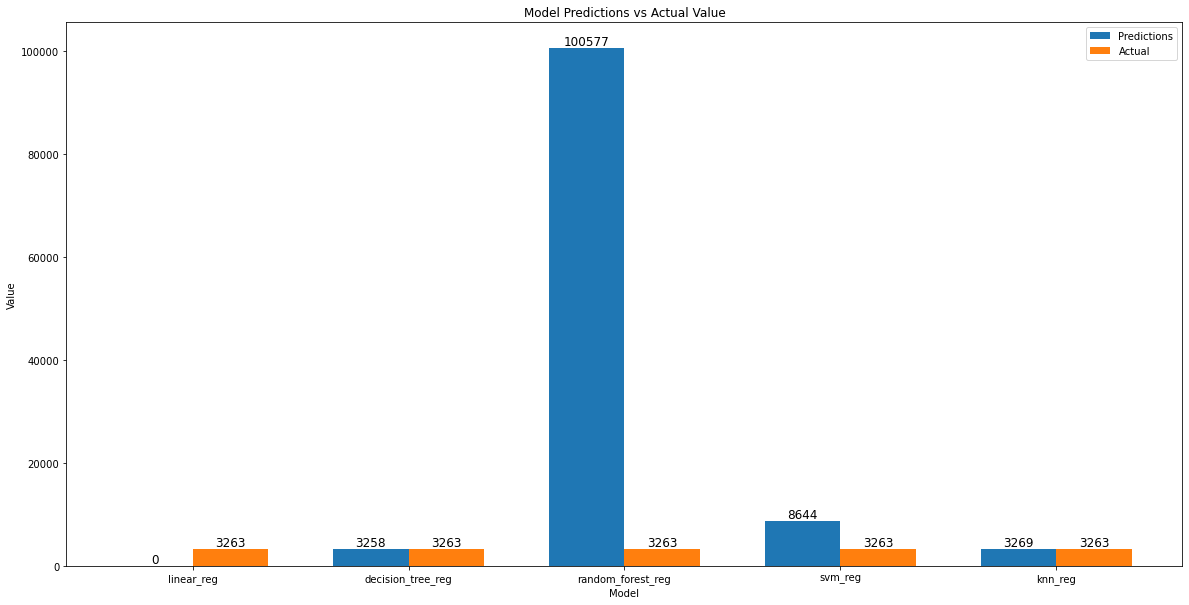

In [35]:
plot_predictions(predictions, testY)

In [ ]:
def getMultiModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')

    # 使用MultiOutputRegressor包装模型
    multioutput_linear_reg = MultiOutputRegressor(linear_reg)
    multioutput_decision_tree_reg = MultiOutputRegressor(decision_tree_reg)
    multioutput_random_forest_reg = MultiOutputRegressor(random_forest_reg)
    multioutput_svm_reg = MultiOutputRegressor(svm_reg)
    multioutput_knn_reg = MultiOutputRegressor(knn_reg)

    # 拟合模型
    multioutput_linear_reg.fit(X_train, y_train)
    multioutput_decision_tree_reg.fit(X_train, y_train)
    multioutput_random_forest_reg.fit(X_train, y_train)
    multioutput_svm_reg.fit(X_train, y_train)
    multioutput_knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'multioutput_linear_reg': multioutput_linear_reg,
        'multioutput_decision_tree_reg': multioutput_decision_tree_reg,
        'multioutput_random_forest_reg': multioutput_random_forest_reg,
        'multioutput_svm_reg': multioutput_svm_reg,
        'multioutput_knn_reg': multioutput_knn_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return multioutput_linear_reg, multioutput_decision_tree_reg, multioutput_random_forest_reg, multioutput_svm_reg, multioutput_knn_reg


def trainMulti(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    multioutput_linear_reg, multioutput_decision_tree_reg, multioutput_random_forest_reg, multioutput_svm_reg, multioutput_knn_reg = getMultiModel(X_train, y_train, save_path)

    # 预测
    y_pred_multioutput_linear_reg = multioutput_linear_reg.predict(X_test)
    y_pred_multioutput_decision_tree_reg = multioutput_decision_tree_reg.predict(X_test)
    y_pred_multioutput_random_forest_reg = multioutput_random_forest_reg.predict(X_test)
    y_pred_multioutput_svm_reg = multioutput_svm_reg.predict(X_test)
    y_pred_multioutput_knn_reg = multioutput_knn_reg.predict(X_test)

    # 计算评估指标
    r2_multioutput_linear_reg = r2_score(y_test, y_pred_multioutput_linear_reg)
    r2_multioutput_decision_tree_reg = r2_score(y_test, y_pred_multioutput_decision_tree_reg)
    r2_multioutput_random_forest_reg = r2_score(y_test, y_pred_multioutput_random_forest_reg)
    r2_multioutput_svm_reg = r2_score(y_test, y_pred_multioutput_svm_reg)
    r2_multioutput_knn_reg = r2_score(y_test, y_pred_multioutput_knn_reg)
    
    print('{:<30} {}'.format('Multi-Output Linear Regression R2:', r2_multioutput_linear_reg))
    print('{:<30} {}'.format('Multi-Output Decision Tree R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_decision_tree_reg))))
    print('{:<30} {}'.format('Multi-Output Random Forest R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_random_forest_reg))))
    print('{:<30} {}'.format('Multi-Output SVM R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_svm_reg))))
    print('{:<30} {}'.format('Multi-Output KNN R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_knn_reg))))

    print('\n')


In [ ]:
your_field1 = '#super_pi_real_time'
inputDF1, result_dict_values1 = get_input_output_Speed(df, your_field1)
your_field2 = '#super_pi_sys_time'
inputDF2, result_dict_values2 = get_input_output_Speed(df, your_field2)

result_dict_values1_list = result_dict_values1[your_field1]
result_dict_values2_list = result_dict_values2[your_field2]

# 列名设置为super_pi_real_time和super_pi_sys_time
df1 = pd.DataFrame(result_dict_values1_list, columns=[your_field1])
df2 = pd.DataFrame(result_dict_values2_list, columns=[your_field2])
# 将df1和df2合并为df3
outPutDFMulti = pd.concat([df1, df2], axis=1)

In [ ]:
# 将outPutDFMulti中的第二列都乘以1000
outPutDFMulti.iloc[:, 1] = outPutDFMulti.iloc[:, 1] * 1000

In [ ]:
outPutDFMulti.head()

In [ ]:
# 判断inputDF1和inputDF2是否相同
print(inputDF1.equals(inputDF2))

In [ ]:
inputDF1.head()

In [ ]:
inputDF1['cvm_cpu'] = pd.to_numeric(inputDF1['cvm_cpu'])
inputDF1['cvm_memory'] = pd.to_numeric(inputDF1['cvm_memory'])
one_hot_df = pd.get_dummies(inputDF1, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDFMulti
print(X.shape)
print(y.shape)

In [ ]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

trainMulti(X, y, save_path)